## Passfilter Analyse

#### Wichtige Gleichungen:

Allgemein: 

$\frac{U_{A}}{U_{E}}$ = $\frac{1}{\sqrt{1 + (\omega RC)^2}}$ = $\frac{|{X_{C}}|}{\sqrt{R^2 + X_{C}^2}}$

$\omega = 2\pi * f$

$X_{C}$ = $\frac{1}{\omega C}$

Grenzfrequenz: $f_{g}$ = $\frac{1}{2\pi RC}$

$\frac{U_{A}}{U_{E}}$ bei Grenzfrequenz $f_{g}$: $\frac{U_{A}}{U_{E}}$ = $\frac{1}{\sqrt{2}}$

In [67]:
import time
from pysinewave import SineWave
import serial
import numpy as np
import math
from tqdm import tqdm
import ipywidgets as widgets

%matplotlib widget
import matplotlib.pyplot as plt

#### Settings:

In [69]:
steps = 1 #steps per nE (10 would equal 100 steps between 10 and 100)
x= []
for exp in range(1,4):
    for fac in range(steps,steps* 10):
        x.append(fac/steps*(10**exp))
#convert to numpy array
x = np.array(x)

#### Search for COM-Ports and list them:

In [4]:
import subprocess
cmd = "python -m serial.tools.list_ports"
p = subprocess.Popen(cmd, shell=True, stdout=subprocess.PIPE, stderr=subprocess.STDOUT)
for line in p.stdout.readlines():
    print(line.decode("UTF-8").rstrip("\n"))

no ports found


#### Connect to COM-Port:

In [5]:
if("ser" in locals()):
    ser.close()
ser = serial.Serial("COM7", 9600, timeout = 1)

#get firmware version
ser.write(b'*idn?\n')
ver=ser.readline().decode("UTF-8")

print(ser.name + " , " + str(ser.is_open) + " , " + ver)

SerialException: could not open port 'COM7': FileNotFoundError(2, 'Das System kann die angegebene Datei nicht finden.', None, 2)

#### Taking measurements:
Generate a Sinwave with the headphone port,
measure its frequency and amplitude,
increase the frequency and repeat

In [66]:
y1, y2 = np.array([]),np.array([])

#voltages and frequencies to switch scaling at
switching_voltages = [0.5,0.2,0.1,0.05,0.02,0.01,0.005,0.002,0.001]
next_voltage_index = 1
switching_frequencies = [10, 100, 1000]

#stop playing sounds
if("sinewave" in locals()):
    sinewave.stop()
#new sinewave object
sinewave = SineWave(pitch_per_second = 1000)
sinewave.play()
sinewave.set_frequency(x[0])

#oscilloscope settings
ser.write(f':tim:scal 1e-2\n'.encode())
ser.write(f':channel1:scale {"{:.1e}".format(0.5)}\n'.encode())
ser.write(f':channel2:scale {"{:.1e}".format(0.5)}\n'.encode())

#confirmation from user
input()
#clear serial buffer
ser.read(100)


for frequency in tqdm(x):
    #play new frequency
    sinewave.set_frequency(frequency)
    #giving oscillosocpe time to update
    time.sleep(1)
    #measuring channel 1
    ser.write(b':meas:sour 1\n')
    ser.write(b':meas:vamp?\n')
    amp1 = ser.readline().decode("UTF-8").rstrip("\n")
    y1.append(float(amp1))
    #measuring channel 2
    ser.write(b':meas:sour 2\n')
    ser.write(b':meas:vamp?\n')
    amp2 = ser.readline().decode("UTF-8").rstrip("\n")
    y2.append(float(amp2))
    
    #scales frequency to improve sampling accuracy (and visibily more appealing)
    if(frequency in switching_frequencies): 
        ts = "{:.1e}".format(0.1/frequency)
        ser.write(f':tim:scal {ts}\n'.encode())
        time.sleep(2)
    
    #scales voltage for accurate measurements in lower voltages
    if(y2[-1]/6 < switching_voltages[next_voltage_index]): 
        ser.write(f':channel2:scale {"{:.1e}".format(voltages[next_voltage_index])}\n'.encode())
        next_voltage_index += 1
        time.sleep(2)

sinewave.stop()

NameError: name 'ser' is not defined

#### Plot those values:

In [6]:
logaxis = widgets.Checkbox(
    description='Logarithmic axis')
display(logaxis)

Checkbox(value=False, description='Logarithmic axis')

[  10   10   10 ... 9970 9980 9990]


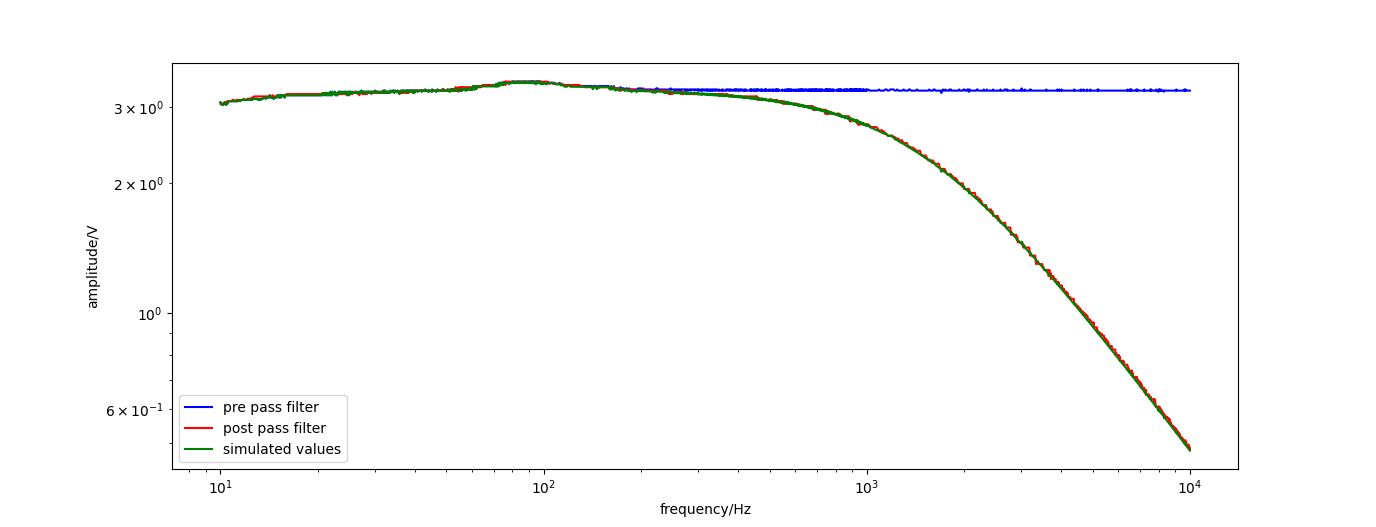

In [61]:
plt.clf()

#simulated values:
#percentual difference between voltages for each frequency
perc_diff = list(map(lambda y1_it, y2_it: y2_it / y1_it, y1, y2))
#use frequency closest to 70.7% as cutoff frequency
fc = x[min(range(len(perc_diff)), key = lambda i: abs(perc_diff[i]-0.707))]
#calculate C*R based on cutoff frequency
CR = 1/(2*math.pi*fc)
ys = y1[-1]/ np.sqrt(1+ (2*math.pi*x * CR)**2)
print(np.around(x).astype(int))
ys = y1[np.where(x==x)]/ np.sqrt(1+ (2*math.pi*x * CR)**2)

#plot values (measured and simulated)
plt.plot(x, y1, 'b-', label = "pre pass filter")
plt.plot(x, y2, 'r-', label = "post pass filter")
plt.plot(x, ys, 'g-', label = "simulated values")

#prepare plot
plt.xlabel("frequency/Hz")
plt.ylabel("amplitude/V")
plt.legend(loc="lower left")

#use logarithmic or linear axis according to user choice
if(logaxis.value):
    plt.xscale('log')
    plt.yscale('log')
else:
    plt.gca().set_xlim([0,x[-1]])
    plt.gca().set_ylim([0,math.ceil(max(y1) * 10)/10]) #y axis from 0 to next decimal


plt.show()

#### Find closest value to cutoff frequency:

In [42]:
print(x,",", y1,",", y2)

[10.0, 10.1, 10.2, 10.3, 10.4, 10.5, 10.600000000000001, 10.700000000000001, 10.8, 10.9, 11.0, 11.100000000000001, 11.200000000000001, 11.299999999999999, 11.399999999999999, 11.5, 11.6, 11.7, 11.799999999999999, 11.899999999999999, 12.0, 12.1, 12.2, 12.3, 12.4, 12.5, 12.6, 12.7, 12.8, 12.9, 13.0, 13.100000000000001, 13.200000000000001, 13.3, 13.4, 13.5, 13.600000000000001, 13.700000000000001, 13.799999999999999, 13.899999999999999, 14.0, 14.1, 14.2, 14.299999999999999, 14.399999999999999, 14.5, 14.6, 14.7, 14.8, 14.9, 15.0, 15.1, 15.2, 15.3, 15.4, 15.5, 15.600000000000001, 15.700000000000001, 15.8, 15.9, 16.0, 16.1, 16.200000000000003, 16.299999999999997, 16.4, 16.5, 16.599999999999998, 16.7, 16.8, 16.9, 17.0, 17.1, 17.2, 17.3, 17.4, 17.5, 17.6, 17.7, 17.8, 17.9, 18.0, 18.1, 18.2, 18.3, 18.400000000000002, 18.5, 18.6, 18.700000000000003, 18.799999999999997, 18.9, 19.0, 19.099999999999998, 19.2, 19.3, 19.4, 19.5, 19.6, 19.7, 19.8, 19.9, 20.0, 20.099999999999998, 20.2, 20.29999999999999

In [63]:
# store previous measurements
%store x
%store y1
%store y2

Stored 'x' (ndarray)
Stored 'y1' (ndarray)
Stored 'y2' (ndarray)


In [71]:
# restore previous measurements
%store -r x
%store -r y1
%store -r y2